# Minplus algebra experiment

This code attempts to learn the 64D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 200     # number of hidden units
layers = 1      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7397.27685546875
iteration 0 loss 6122.3701171875


iteration 5000 loss 7.731162071228027


iteration 10000 loss 0.4033791422843933


iteration 15000 loss 0.18210989236831665


iteration 20000 loss 0.12549230456352234


iteration 25000 loss 0.09167692065238953


iteration 30000 loss 0.07611522823572159


iteration 35000 loss 0.06388569623231888


iteration 40000 loss 0.05619924142956734


iteration 45000 loss 0.05146712437272072


iteration 50000 loss 0.0476488433778286


iteration 55000 loss 0.04147167131304741


iteration 60000 loss 0.03990444913506508


iteration 65000 loss 0.03595814108848572


iteration 70000 loss 0.03398042172193527


iteration 75000 loss 0.03149515017867088


iteration 80000 loss 0.029926152899861336


iteration 85000 loss 0.030608538538217545


iteration 90000 loss 0.027196938171982765


iteration 95000 loss 0.026000605896115303


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.026332708075642586


iteration 105000 loss 0.024374524131417274


iteration 110000 loss 0.023253772407770157


iteration 115000 loss 0.02240382693707943


iteration 120000 loss 0.021575508639216423


iteration 125000 loss 0.02081635780632496


iteration 130000 loss 0.02012617141008377


iteration 135000 loss 0.01957651972770691


iteration 140000 loss 0.019012602046132088


iteration 145000 loss 0.018523583188652992


iteration 150000 loss 0.01807304657995701


iteration 155000 loss 0.1057903990149498


iteration 160000 loss 0.01726386696100235


iteration 165000 loss 0.016870442777872086


iteration 170000 loss 0.01655302196741104


iteration 175000 loss 0.016199316829442978


iteration 180000 loss 0.015855934470891953


iteration 185000 loss 0.015550910495221615


iteration 190000 loss 0.015253725461661816


iteration 195000 loss 0.014968291856348515


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.014692985452711582


iteration 205000 loss 0.014555852860212326


iteration 210000 loss 0.014279571361839771


iteration 215000 loss 0.013993331231176853


iteration 220000 loss 0.013756685890257359


iteration 225000 loss 0.013493301346898079


iteration 230000 loss 0.013253931887447834


iteration 235000 loss 0.013016808778047562


iteration 240000 loss 0.012791065499186516


iteration 245000 loss 0.012605873867869377


iteration 250000 loss 0.012405877001583576


iteration 255000 loss 0.012213082984089851


iteration 260000 loss 0.012032525613904


iteration 265000 loss 0.011835146695375443


iteration 270000 loss 0.011657187715172768


iteration 275000 loss 0.011489869095385075


iteration 280000 loss 0.011338401585817337


iteration 285000 loss 0.011173165403306484


iteration 290000 loss 0.011007868684828281


iteration 295000 loss 0.010873722843825817


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.01072527002543211


iteration 305000 loss 0.010676363483071327


iteration 310000 loss 0.010468955151736736


iteration 315000 loss 0.010256540961563587


iteration 320000 loss 0.010053678415715694


iteration 325000 loss 0.009857960045337677


iteration 330000 loss 0.009669485501945019


iteration 335000 loss 0.00949006900191307


iteration 340000 loss 0.0093176094815135


iteration 345000 loss 0.009152239188551903


iteration 350000 loss 0.008993732742965221


iteration 355000 loss 0.008842743933200836


iteration 360000 loss 0.00869887974113226


iteration 365000 loss 0.008561012335121632


iteration 370000 loss 0.008430125191807747


iteration 375000 loss 0.008303960785269737


iteration 380000 loss 0.008183185011148453


iteration 385000 loss 0.008067001588642597


iteration 390000 loss 0.007955913431942463


iteration 395000 loss 0.007848762907087803


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.007744822651147842


iteration 405000 loss 0.007722312584519386


iteration 410000 loss 0.007691293954849243


iteration 415000 loss 0.007662253919988871


iteration 420000 loss 0.00763434823602438


iteration 425000 loss 0.0076072933152318


iteration 430000 loss 0.007580877281725407


iteration 435000 loss 0.007554978597909212


iteration 440000 loss 0.0075294505804777145


iteration 445000 loss 0.007504255510866642


iteration 450000 loss 0.0074793491512537


iteration 455000 loss 0.0074547394178807735


iteration 460000 loss 0.007430372294038534


iteration 465000 loss 0.0074062407948076725


iteration 470000 loss 0.007382302079349756


iteration 475000 loss 0.007358570117503405


iteration 480000 loss 0.007335004862397909


iteration 485000 loss 0.007311664521694183


iteration 490000 loss 0.0072884769178926945


iteration 495000 loss 0.007265440188348293


L2 loss -- Plot

loss -162.5889892578125


loss -514.0452270507812


loss -633.8507080078125


loss -713.406494140625


loss -780.1641235351562


loss -837.8323974609375


loss -886.8685302734375


loss -927.4111938476562


loss -959.953125


loss -985.272216796875


loss -1004.2438354492188


loss -1017.9893798828125


loss -1027.71435546875


loss -1034.3916015625


loss -1038.7479248046875


loss -1041.373291015625


loss -1042.793212890625


loss -1043.46337890625


loss -1043.7320556640625


loss -1043.8203125


loss -1043.8426513671875


loss -1043.8468017578125


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.847412109375


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


loss -1043.8472900390625


final mse:  1.8148728075928489e-09
max, min: 6.1251054 -7.295032
loss -162.5889892578125


loss -514.36767578125


loss -636.7310180664062


loss -718.108154296875


loss -787.0115966796875


loss -846.6179809570312


loss -897.723876953125


loss -941.3455200195312


loss -978.485107421875


loss -1009.7764892578125


loss -1035.4630126953125


loss -1055.5946044921875


loss -1070.382568359375


loss -1080.39794921875


loss -1086.58447265625


loss -1090.0584716796875


loss -1091.8284912109375


loss -1092.640625


loss -1092.970703125


loss -1093.0858154296875


loss -1093.1185302734375


loss -1093.1256103515625


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


loss -1093.126708984375


final mse:  1.985851261210314e-09
max, min: 7.0487404 -7.260399


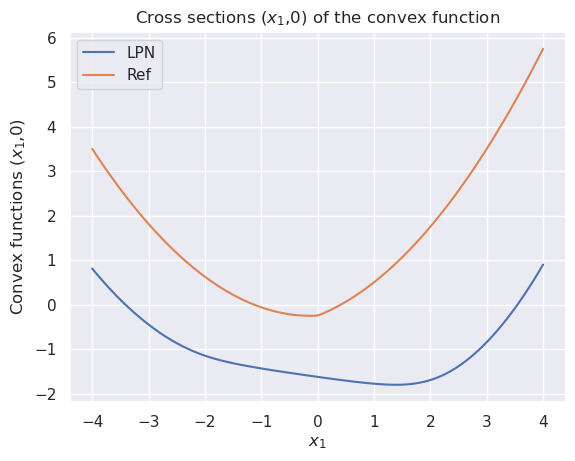

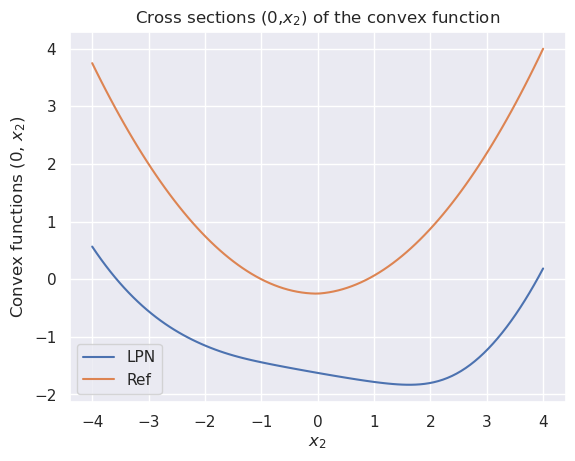

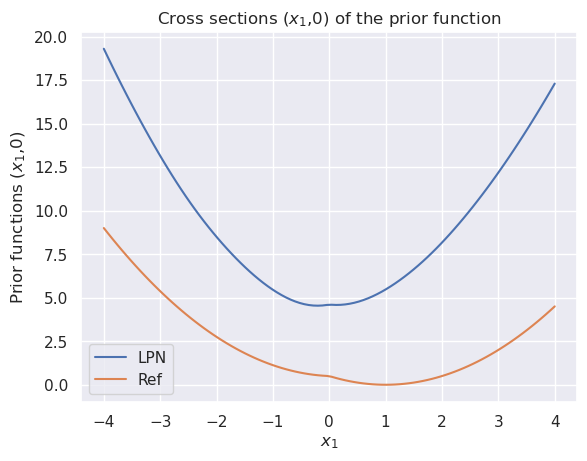

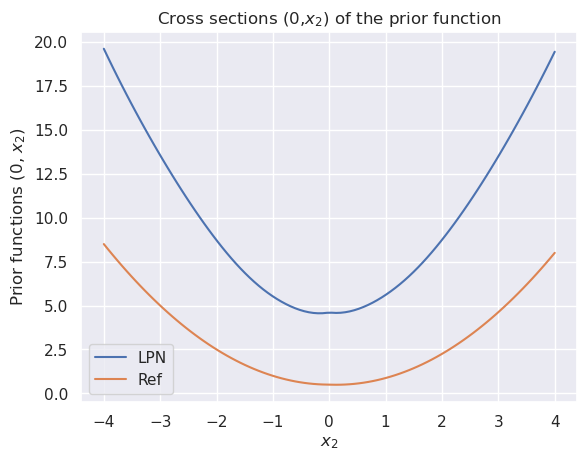

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 4877.17822265625
iteration 0 loss 4397.40234375


iteration 5000 loss 1.9157917499542236


iteration 10000 loss 0.762113630771637


iteration 15000 loss 0.2899487614631653


iteration 20000 loss 0.1473873406648636


iteration 25000 loss 0.10247017443180084


iteration 30000 loss 0.08074728399515152


iteration 35000 loss 0.06792964786291122


iteration 40000 loss 0.05916634202003479


iteration 45000 loss 0.05279965698719025


iteration 50000 loss 0.047380659729242325


iteration 55000 loss 0.043709684163331985


iteration 60000 loss 0.040971219539642334


iteration 65000 loss 0.03777965530753136


iteration 70000 loss 0.036124762147665024


iteration 75000 loss 0.03433340787887573


iteration 80000 loss 0.033302273601293564


iteration 85000 loss 0.031546831130981445


iteration 90000 loss 0.030472615733742714


iteration 95000 loss 0.029006127268075943


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.02884303592145443


iteration 105000 loss 0.027701271697878838


iteration 110000 loss 0.026592230424284935


iteration 115000 loss 0.02575686015188694


iteration 120000 loss 0.024930452927947044


iteration 125000 loss 0.024193935096263885


iteration 130000 loss 0.023612158372998238


iteration 135000 loss 0.022980019450187683


iteration 140000 loss 0.022455105558037758


iteration 145000 loss 0.021906567737460136


iteration 150000 loss 0.021354736760258675


iteration 155000 loss 0.02085854485630989


iteration 160000 loss 0.02042374201118946


iteration 165000 loss 0.020048553124070168


iteration 170000 loss 0.01966889016330242


iteration 175000 loss 0.019313786178827286


iteration 180000 loss 0.018939096480607986


iteration 185000 loss 0.018635617569088936


iteration 190000 loss 0.01830415241420269


iteration 195000 loss 0.01802554354071617


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.01776382327079773


iteration 205000 loss 0.01766260154545307


iteration 210000 loss 0.01731674186885357


iteration 215000 loss 0.01699841581285


iteration 220000 loss 0.01670563966035843


iteration 225000 loss 0.016426876187324524


iteration 230000 loss 0.016131551936268806


iteration 235000 loss 0.01585470139980316


iteration 240000 loss 0.01560960803180933


iteration 245000 loss 0.015359219163656235


iteration 250000 loss 0.015129209496080875


iteration 255000 loss 0.014902294613420963


iteration 260000 loss 0.014696728438138962


iteration 265000 loss 0.014499145559966564


iteration 270000 loss 0.014294024556875229


iteration 275000 loss 0.014086300507187843


iteration 280000 loss 0.013919152319431305


iteration 285000 loss 0.013749734498560429


iteration 290000 loss 0.01357973925769329


iteration 295000 loss 0.013418898917734623


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.013257777318358421


iteration 305000 loss 0.013165111653506756


iteration 310000 loss 0.012981221079826355


iteration 315000 loss 0.01281021349132061


iteration 320000 loss 0.01264813169836998


iteration 325000 loss 0.012493010610342026


iteration 330000 loss 0.012343842536211014


iteration 335000 loss 0.012199629098176956


iteration 340000 loss 0.012060084380209446


iteration 345000 loss 0.011924676597118378


iteration 350000 loss 0.011792771518230438


iteration 355000 loss 0.011664251796901226


iteration 360000 loss 0.01153850182890892


iteration 365000 loss 0.011415490880608559


iteration 370000 loss 0.011294891126453876


iteration 375000 loss 0.011177297681570053


iteration 380000 loss 0.011062487959861755


iteration 385000 loss 0.010950525291264057


iteration 390000 loss 0.01084149070084095


iteration 395000 loss 0.0107351029291749


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.010631815530359745


iteration 405000 loss 0.010614919476211071


iteration 410000 loss 0.010595494881272316


iteration 415000 loss 0.010577289387583733


iteration 420000 loss 0.010559814982116222


iteration 425000 loss 0.010542848147451878


iteration 430000 loss 0.010526258498430252


iteration 435000 loss 0.010509989224374294


iteration 440000 loss 0.01049396488815546


iteration 445000 loss 0.010478164069354534


iteration 450000 loss 0.01046256348490715


iteration 455000 loss 0.010447139851748943


iteration 460000 loss 0.010431875474750996


iteration 465000 loss 0.010416777804493904


iteration 470000 loss 0.010401816107332706


iteration 475000 loss 0.010387000627815723


iteration 480000 loss 0.01037229597568512


iteration 485000 loss 0.010357699356973171


iteration 490000 loss 0.010343206115067005


iteration 495000 loss 0.010328815318644047


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


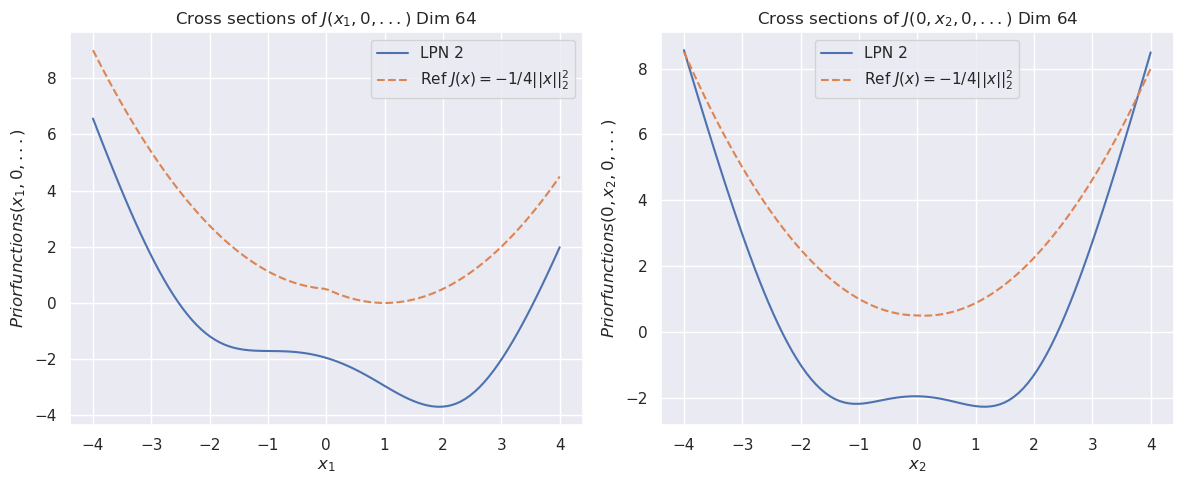

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)